### Loading Models

In [16]:
from train_eval import train, evaluate
from model import get_model
from data_utils import get_cifar100_loaders
import torch.nn as nn
import torch.optim as optim
import torch
train_loader, test_loader = get_cifar100_loaders(batch_size=128)
student = get_model('vgg11_bn', pretrained=False)
teacher = get_model('vgg16_bn', pretrained=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [17]:
teacher.classifier = nn.Flatten(start_dim=1)
teacher = teacher.to("cuda")
teacher.eval()
for parameters in teacher.parameters():
  parameters.requires_grad = False

### Creating 4 Students

In [19]:
from vgg import small_vgg_student, vgg11_bn_cifar100
from torchsummary import summary
import torch.nn as nn
import torch

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_vgg11 = vgg11_bn_cifar100().to(device)
print("--- Baseline VGG11-BN (Budget) ---")
summary(baseline_vgg11, (3, 32, 32))
baseline_params = count_parameters(baseline_vgg11)

student_template = small_vgg_student().to(device)
print("\n--- SmallVGG Student ---")
summary(student_template, (3, 32, 32))
student_params = count_parameters(student_template)

total_student_params = 4 * student_params
print(f"\nParameter Count Verification:")
print(f"Baseline VGG11-BN parameters: {baseline_params:,}")
print(f"Single SmallVGG student parameters: {student_params:,}")
print(f"Total for 4 students: {total_student_params:,}")

if total_student_params <= baseline_params:
    print("Constraint met: Total student parameters are less than or equal to the baseline.")
else:
    print("Constraint FAILED: Total student parameters exceed the baseline.")

students = [small_vgg_student() for _ in range(4)]
print(f"\nSuccessfully created {len(students)} student models for independent training.")

--- Baseline VGG11-BN (Budget) ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
    

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from vgg import small_vgg_student, vgg11_bn_cifar100
from data_utils import get_cifar100_loaders

class EnsembleStudent(nn.Module):
    def __init__(self, students: list):
        super(EnsembleStudent, self).__init__()
        if len(students) != 4:
            raise ValueError("This ensemble requires exactly 4 student models.")

        self.student1 = students[0]
        self.student2 = students[1]
        self.student3 = students[2]
        self.student4 = students[3]

        for student in [self.student1, self.student2, self.student3, self.student4]:
            for param in student.parameters():
                param.requires_grad = False

        self.final_classifier = nn.Sequential(
            nn.Linear(128 * 4, 1024),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(1024, 100)
        )

    def forward(self, x):
        f1 = self.student1(x)
        f2 = self.student2(x)
        f3 = self.student3(x)
        f4 = self.student4(x)

        combined_features = torch.cat([f1, f2, f3, f4], dim=1)
        output = self.final_classifier(combined_features)
        return output

### Stage 1

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
students = [small_vgg_student().to(device) for _ in range(4)]
STUDENT_EPOCHS = 20
ENSEMBLE_EPOCHS = 5
LR = 1e-4

Using device: cuda


In [22]:
student_loss_history = {f'student_{i+1}': [] for i in range(4)}

for i, student in enumerate(students):
    print(f"--- Training Student {i+1}/{len(students)} ---")
    optimizer = optim.Adam(student.parameters(), lr=LR)
    criterion = nn.MSELoss()

    for epoch in range(STUDENT_EPOCHS):
        student.train()
        teacher.eval()
        running_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Student {i+1} Epoch {epoch+1}")
        for inputs, _ in progress_bar:
            inputs = inputs.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_features = teacher(inputs)
                target_features = teacher_features[:, 128*i : 128*(i+1)]

            student_features = student(inputs)
            loss = criterion(student_features, target_features)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(mse_loss=running_loss / len(progress_bar))

        epoch_loss = running_loss / len(train_loader)
        student_loss_history[f'student_{i+1}'].append(epoch_loss)

    torch.save(student.state_dict(), f'student_{i+1}.pth')

print("\nFinished training all students.")

--- Training Student 1/4 ---


Student 1 Epoch 20: 100%|██████████| 391/391 [00:21<00:00, 18.46it/s, mse_loss=0.143]


--- Training Student 2/4 ---


Student 2 Epoch 20: 100%|██████████| 391/391 [00:19<00:00, 19.77it/s, mse_loss=0.151]


--- Training Student 3/4 ---


Student 3 Epoch 20: 100%|██████████| 391/391 [00:19<00:00, 19.69it/s, mse_loss=0.147]


--- Training Student 4/4 ---


Student 4 Epoch 20: 100%|██████████| 391/391 [00:20<00:00, 18.84it/s, mse_loss=0.149]



Finished training all students.


### Stage 2

In [28]:
trained_students = [small_vgg_student() for _ in range(4)]
ENSEMBLE_EPOCHS = 20
for i, student in enumerate(trained_students):
    student.load_state_dict(torch.load(f'student_{i+1}.pth'))
    student.to(device)

ensemble_model = EnsembleStudent(trained_students).to(device)

optimizer = optim.Adam(ensemble_model.final_classifier.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

ensemble_history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(ENSEMBLE_EPOCHS):
    ensemble_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Ensemble Epoch {epoch+1}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        progress_bar.set_postfix(loss=running_loss/len(progress_bar), acc=f'{100.*correct/total:.2f}%')

    ensemble_history['train_loss'].append(running_loss / len(train_loader))
    ensemble_history['train_acc'].append(100. * correct / total)

    ensemble_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ensemble_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    ensemble_history['val_loss'].append(val_loss / len(test_loader))
    ensemble_history['val_acc'].append(100. * val_correct / val_total)

    print(f"Epoch {epoch+1} Summary: Train Acc: {ensemble_history['train_acc'][-1]:.2f}% | Val Acc: {ensemble_history['val_acc'][-1]:.2f}%")

print("\nFinished fine-tuning the ensemble.")

Ensemble Epoch 1: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s, acc=26.61%, loss=3.52]


Epoch 1 Summary: Train Acc: 26.61% | Val Acc: 38.47%


Ensemble Epoch 2: 100%|██████████| 391/391 [00:22<00:00, 17.52it/s, acc=37.53%, loss=2.49]


Epoch 2 Summary: Train Acc: 37.53% | Val Acc: 40.44%


Ensemble Epoch 3: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s, acc=39.91%, loss=2.33]


Epoch 3 Summary: Train Acc: 39.91% | Val Acc: 41.47%


Ensemble Epoch 4: 100%|██████████| 391/391 [00:22<00:00, 17.65it/s, acc=40.98%, loss=2.27]


Epoch 4 Summary: Train Acc: 40.98% | Val Acc: 41.70%


Ensemble Epoch 5: 100%|██████████| 391/391 [00:22<00:00, 17.73it/s, acc=41.60%, loss=2.24]


Epoch 5 Summary: Train Acc: 41.60% | Val Acc: 42.04%


Ensemble Epoch 6: 100%|██████████| 391/391 [00:21<00:00, 18.40it/s, acc=42.30%, loss=2.21]


Epoch 6 Summary: Train Acc: 42.30% | Val Acc: 42.09%


Ensemble Epoch 7: 100%|██████████| 391/391 [00:21<00:00, 18.62it/s, acc=42.62%, loss=2.2]


Epoch 7 Summary: Train Acc: 42.62% | Val Acc: 42.74%


Ensemble Epoch 8: 100%|██████████| 391/391 [00:20<00:00, 18.84it/s, acc=42.76%, loss=2.18]


Epoch 8 Summary: Train Acc: 42.76% | Val Acc: 42.64%


Ensemble Epoch 9: 100%|██████████| 391/391 [00:21<00:00, 18.11it/s, acc=43.32%, loss=2.17]


Epoch 9 Summary: Train Acc: 43.32% | Val Acc: 42.92%


Ensemble Epoch 10: 100%|██████████| 391/391 [00:22<00:00, 17.38it/s, acc=43.34%, loss=2.16]


Epoch 10 Summary: Train Acc: 43.34% | Val Acc: 43.17%


Ensemble Epoch 11: 100%|██████████| 391/391 [00:22<00:00, 17.35it/s, acc=43.51%, loss=2.15]


Epoch 11 Summary: Train Acc: 43.51% | Val Acc: 43.09%


Ensemble Epoch 12: 100%|██████████| 391/391 [00:22<00:00, 17.66it/s, acc=43.59%, loss=2.14]


Epoch 12 Summary: Train Acc: 43.59% | Val Acc: 43.18%


Ensemble Epoch 13: 100%|██████████| 391/391 [00:22<00:00, 17.68it/s, acc=44.02%, loss=2.13]


Epoch 13 Summary: Train Acc: 44.02% | Val Acc: 43.08%


Ensemble Epoch 14: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s, acc=43.94%, loss=2.13]


Epoch 14 Summary: Train Acc: 43.94% | Val Acc: 43.23%


Ensemble Epoch 15: 100%|██████████| 391/391 [00:21<00:00, 18.52it/s, acc=44.03%, loss=2.13]


Epoch 15 Summary: Train Acc: 44.03% | Val Acc: 43.32%


Ensemble Epoch 16: 100%|██████████| 391/391 [00:20<00:00, 19.15it/s, acc=44.16%, loss=2.13]


Epoch 16 Summary: Train Acc: 44.16% | Val Acc: 43.44%


Ensemble Epoch 17: 100%|██████████| 391/391 [00:21<00:00, 18.61it/s, acc=44.38%, loss=2.12]


Epoch 17 Summary: Train Acc: 44.38% | Val Acc: 43.26%


Ensemble Epoch 18: 100%|██████████| 391/391 [00:21<00:00, 18.41it/s, acc=44.36%, loss=2.11]


Epoch 18 Summary: Train Acc: 44.36% | Val Acc: 43.42%


Ensemble Epoch 19: 100%|██████████| 391/391 [00:21<00:00, 18.12it/s, acc=44.35%, loss=2.11]


Epoch 19 Summary: Train Acc: 44.35% | Val Acc: 43.50%


Ensemble Epoch 20: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s, acc=44.59%, loss=2.11]


Epoch 20 Summary: Train Acc: 44.59% | Val Acc: 43.50%

Finished fine-tuning the ensemble.


### Plots

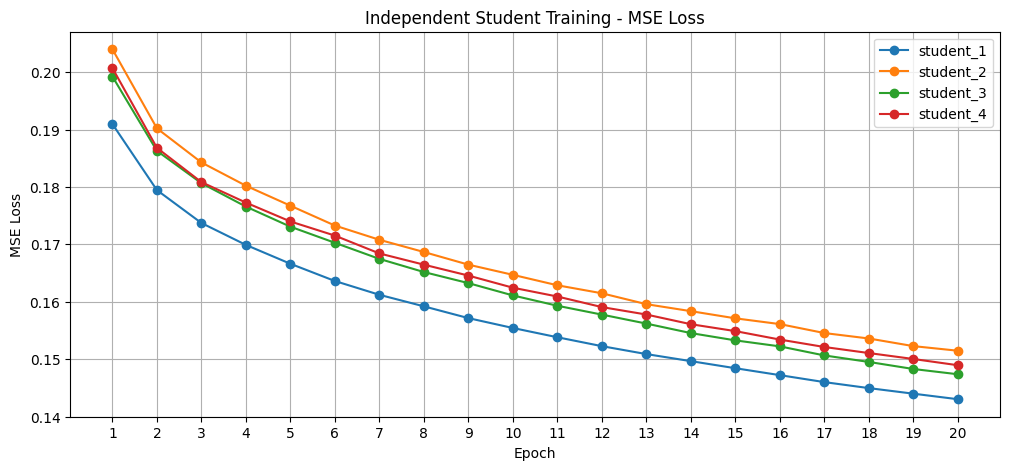

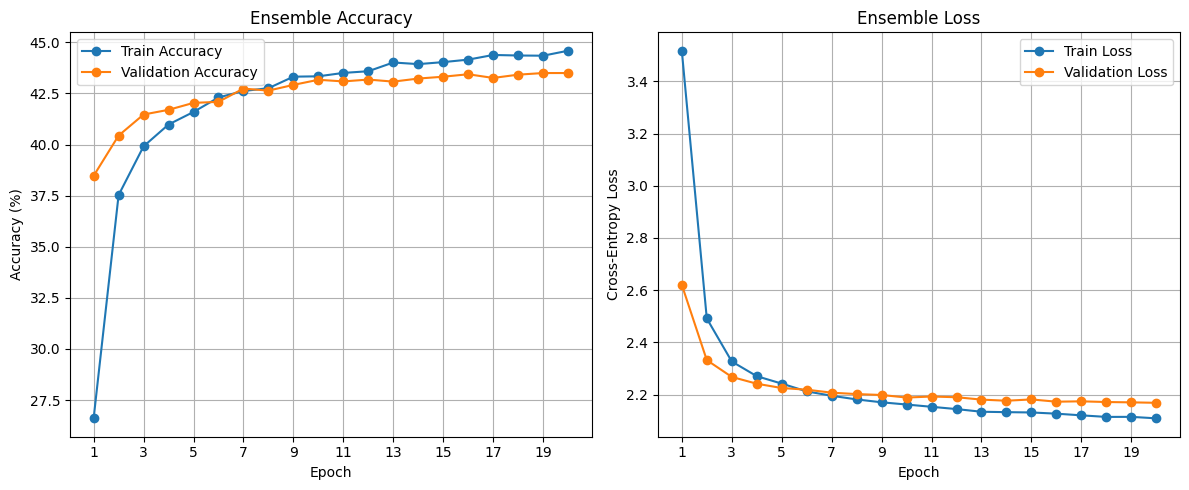


--- Final Comparison Table ---
                             Model Parameter Count     Test Accuracy (%)
                Student 1-4 (each)         595,008 N/A (Feature Learner)
Ensemble (4 Students + Classifier)       3,007,844                 43.50
             Single VGG11 Baseline      28,518,244                 48.71


In [29]:
plt.figure(figsize=(12, 5))
for student_name, losses in student_loss_history.items():
    plt.plot(range(1, STUDENT_EPOCHS + 1), losses, marker='o', label=student_name)
plt.title('Independent Student Training - MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.xticks(range(1, STUDENT_EPOCHS + 1))
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, ENSEMBLE_EPOCHS + 1), ensemble_history['train_acc'], marker='o', label='Train Accuracy')
plt.plot(range(1, ENSEMBLE_EPOCHS + 1), ensemble_history['val_acc'], marker='o', label='Validation Accuracy')
plt.title('Ensemble Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, ENSEMBLE_EPOCHS + 1, 2))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, ENSEMBLE_EPOCHS + 1), ensemble_history['train_loss'], marker='o', label='Train Loss')
plt.plot(range(1, ENSEMBLE_EPOCHS + 1), ensemble_history['val_loss'], marker='o', label='Validation Loss')
plt.title('Ensemble Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.xticks(range(1, ENSEMBLE_EPOCHS + 1, 2))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


baseline_vgg11 = vgg11_bn_cifar100()
baseline_params = count_parameters(baseline_vgg11)
student_template = small_vgg_student()
student_params = count_parameters(student_template)
ensemble_classifier_params = count_parameters(ensemble_model.final_classifier)
total_ensemble_params = (4 * student_params) + ensemble_classifier_params

final_ensemble_accuracy = ensemble_history['val_acc'][-1]
BASELINE_SINGLE_STUDENT_ACC = 48.71

report_data = {
    'Model': ['Student 1-4 (each)', 'Ensemble (4 Students + Classifier)', 'Single VGG11 Baseline'],
    'Parameter Count': [f'{student_params:,}', f'{total_ensemble_params:,}', f'{baseline_params:,}'],
    'Test Accuracy (%)': ['N/A (Feature Learner)', f'{final_ensemble_accuracy:.2f}', f'{BASELINE_SINGLE_STUDENT_ACC:.2f}']
}
df = pd.DataFrame(report_data)

print("\n--- Final Comparison Table ---")
print(df.to_string(index=False))


--- Evaluating Individual Student 1 ---


Student 1 Epoch 1 -> Val Accuracy: 12.34%


Student 1 Epoch 2 -> Val Accuracy: 24.97%


Student 1 Epoch 3 -> Val Accuracy: 28.72%


Student 1 Epoch 4 -> Val Accuracy: 30.06%


Student 1 Epoch 5 -> Val Accuracy: 31.05%

--- Evaluating Individual Student 2 ---


Student 2 Epoch 1 -> Val Accuracy: 13.56%


Student 2 Epoch 2 -> Val Accuracy: 25.02%


Student 2 Epoch 3 -> Val Accuracy: 29.60%


Student 2 Epoch 4 -> Val Accuracy: 31.12%


Student 2 Epoch 5 -> Val Accuracy: 32.31%

--- Evaluating Individual Student 3 ---


Student 3 Epoch 1 -> Val Accuracy: 12.59%


Student 3 Epoch 2 -> Val Accuracy: 25.89%


Student 3 Epoch 3 -> Val Accuracy: 30.07%


Student 3 Epoch 4 -> Val Accuracy: 31.94%


Student 3 Epoch 5 -> Val Accuracy: 32.92%

--- Evaluating Individual Student 4 ---


Student 4 Epoch 1 -> Val Accuracy: 11.90%


Student 4 Epoch 2 -> Val Accuracy: 25.23%


Student 4 Epoch 3 -> Val Accuracy: 29.00%


Student 4 Epoch 4 -> Val Accuracy: 30.82%


Student 4 Epoch 5 -> Val Accuracy: 31.83%

--- Individual Student Final Accuracies ---
Student 1: 31.05%
Student 2: 32.31%
Student 3: 32.92%
Student 4: 31.83%


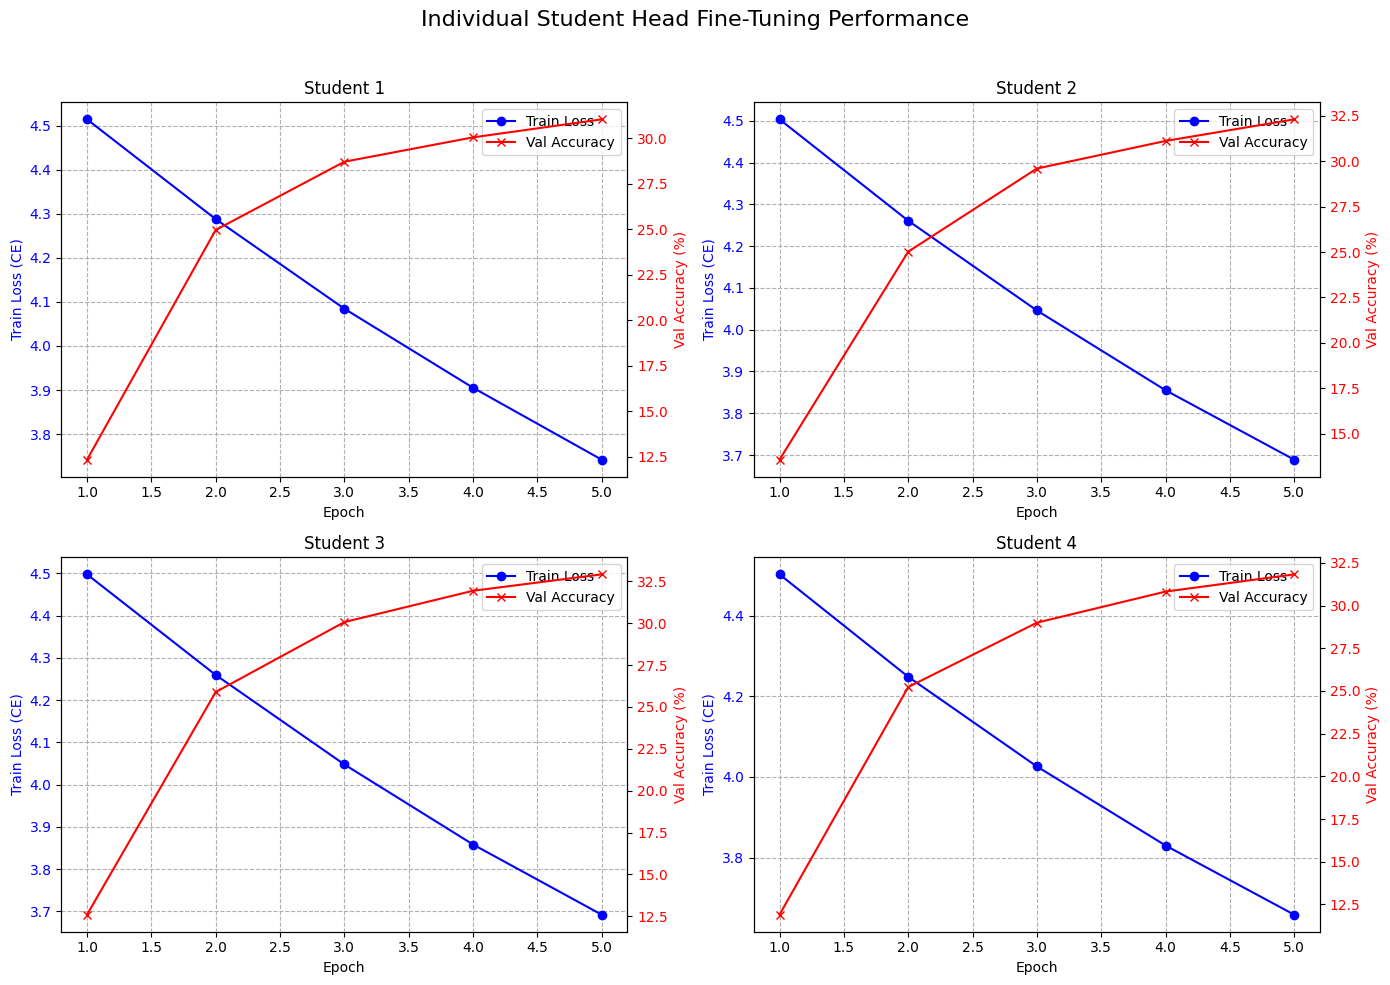

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- A. Setup and Wrapper Class ---

# A wrapper to attach a trainable classifier head to a frozen student
class StudentClassifier(nn.Module):
    def __init__(self, student_feature_extractor: nn.Module):
        super(StudentClassifier, self).__init__()
        self.student = student_feature_extractor
        # Freeze the student's learned features
        for param in self.student.parameters():
            param.requires_grad = False

        # Add a new, trainable classifier head
        self.classifier_head = nn.Linear(128, 100)

    def forward(self, x):
        features = self.student(x)
        logits = self.classifier_head(features)
        return logits

# --- B. Fine-Tuning and Evaluation Loop ---

HEAD_TRAINING_EPOCHS = 5
LR = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

individual_histories = {}
final_accuracies = {}

for i in range(4):
    student_idx = i + 1
    print(f"\n--- Evaluating Individual Student {student_idx} ---")

    # Load the pre-trained student feature extractor
    student_model = small_vgg_student()
    student_model.load_state_dict(torch.load(f'student_{student_idx}.pth', map_location=device))

    # Create the wrapper model
    eval_model = StudentClassifier(student_model).to(device)

    # The optimizer ONLY sees the parameters of the new classifier head
    optimizer = optim.Adam(eval_model.classifier_head.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(HEAD_TRAINING_EPOCHS):
        eval_model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Student {student_idx} Head Epoch {epoch+1}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = eval_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        history['train_loss'].append(running_loss / len(train_loader))

        eval_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = eval_model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        accuracy = 100. * correct / total
        history['val_acc'].append(accuracy)
        print(f"Student {student_idx} Epoch {epoch+1} -> Val Accuracy: {accuracy:.2f}%")

    individual_histories[f'Student {student_idx}'] = history
    final_accuracies[f'Student {student_idx}'] = history['val_acc'][-1]

print("\n--- Individual Student Final Accuracies ---")
for name, acc in final_accuracies.items():
    print(f"{name}: {acc:.2f}%")

# --- C. Plotting the Results ---

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Individual Student Head Fine-Tuning Performance', fontsize=16)
axes = axes.flatten()

for i, (name, history) in enumerate(individual_histories.items()):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # Plot Loss on primary y-axis
    p1, = ax1.plot(range(1, HEAD_TRAINING_EPOCHS + 1), history['train_loss'], 'b-', marker='o', label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss (CE)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot Accuracy on secondary y-axis
    p2, = ax2.plot(range(1, HEAD_TRAINING_EPOCHS + 1), history['val_acc'], 'r-', marker='x', label='Val Accuracy')
    ax2.set_ylabel('Val Accuracy (%)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    ax1.set_title(name)
    ax1.grid(True, linestyle='--')
    ax1.legend(handles=[p1, p2])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()